# Import

In [1]:
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import math
import glob
import json
import seaborn as sns
from torchviz import make_dot, make_dot_from_trace
from skimage import io, transform
from torch import tensor
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output
import sys
sys.path.insert(0, '/home/caitao/Project/dl-localization')
from input_output import Default
from utility import Utility
from torch._six import container_abcs, string_classes, int_classes
import re
np_str_obj_array_pattern = re.compile(r'[SaUO]')
default_collate_err_msg_format = (
    "default_collate: batch must contain tensors, numpy arrays, numbers, "
    "dicts or lists; found {}")

# plt.rcParams['font.size'] = 60
# # plt.rcParams['font.weight'] = 'bold'
# # plt.rcParams['axes.labelweight'] = 'bold'
# plt.rcParams['lines.linewidth'] = 10
# plt.rcParams['lines.markersize'] = 15


# 1 Common modules

In [2]:
class MinMaxNormalize:
    '''Min max normalization, the new bound is (lower, upper)
    '''
    def __init__(self, lower=0, upper=1):
        assert isinstance(lower, (int, float))
        assert isinstance(upper, (int, float))
        self.lower = lower
        self.upper = upper

    def __call__(self, matrix):
        minn = matrix.min()
        maxx = matrix.max()
        matrix = (matrix - minn) / (maxx - minn)
        if self.lower != 0 or self.upper != 1:
            matrix = self.lower + matrix * (self.upper - self.lower)
        return matrix.astype(np.float32)


class UniformNormalize:
    '''Set a uniform threshold accross all samples
    '''
    def __init__(self, noise_floor):
        self.noise_floor = noise_floor

    def __call__(self, matrix):
        matrix -= self.noise_floor
        matrix /= (-self.noise_floor/2)
        return matrix.astype(np.float32)


class Metrics:
    '''Evaluation metrics
    '''
    @staticmethod
    def localization_error_image_continuous(pred_batch, pred_ntx, truth_batch, index, grid_len, peak_threshold, debug=False):
        '''Continuous -- for single TX
           euclidian error when modeling the output representation is a matrix (image)
           both pred and truth are batches, typically a batch of 32
           now both prediction and truth are continuous numbers
        Args:
            pred_batch:  numpy.ndarray -- size=(N, 1, 100, 100)
            truth_batch: numpy.ndarray -- size=(N, num_tx, 2)
        Return:
            pred_locs -- list<np.ndarray>
            errors    -- list<list>
            misses    -- list
            false     -- list
        '''
        def float_target(pred_matrix, pred_peaks):
            new_pred_peaks = []
            for pred_x, pred_y in pred_peaks:
                sum_weight = 0
                neighbor = []
                for d in [(0, 0), (-1, 0), (0, 1), (1, 0), (0, -1)]:
                    nxt = (pred_x + d[0], pred_y + d[1])
                    if 0 <= nxt[0] < grid_len and 0 <= nxt[1] < grid_len:
                        neighbor.append(((nxt[0] + 0.5, nxt[1] + 0.5), pred[nxt[0]][nxt[1]]))
                        sum_weight += pred_matrix[nxt[0]][nxt[1]]
                pred_x, pred_y = 0, 0
                for n in neighbor:
                    loc = n[0]
                    w   = n[1]
                    pred_x += loc[0] / sum_weight * w
                    pred_y += loc[1] / sum_weight * w
                new_pred_peaks.append((pred_x, pred_y))
            return new_pred_peaks

        pred_locs = []
        errors = []
        misses = []
        falses = []
        for i, pred, pred_n, truth, indx in zip(range(len(pred_batch)), pred_batch, pred_ntx, truth_batch, index):
            # 1: get the multiple predicted locations
            pred = pred[0]           # there is only one channel
            pred_peaks, _ = Utility.detect_peak(pred, np.round(pred_n, 0), peak_threshold)         # get the predictions  TIME: 23 milliseconds
            pred_peaks = float_target(pred, pred_peaks)
            # 2: do a matching and get the error
            radius_threshold = Default.grid_length * Default.error_threshold
            error, miss, false = Utility.compute_error(pred_peaks, truth, radius_threshold, False)
            errors.append(error)
            misses.append(miss)
            falses.append(false)
            if debug:
                print(i, indx, 'pred', [(round(loc[0], 2), round(loc[1], 2)) for loc in pred_peaks], '; truth', \
                      [(round(loc[0], 2), round(loc[1], 2)) for loc in truth], ' ; error', error, ' ; miss', miss, ' ; false', false)
        return errors, misses, falses

    @staticmethod
    def mseloss(pred, y):
        '''
        Args:
            pred -- np.ndarray, n=2
            y    -- np.ndarray, n=2
        Return:
            float
        '''
        n = len(pred) * len(pred[0])
        summ = np.sum((pred - y)**2)
        return summ / n

In [3]:
def my_padding(batch, max_len):
    """add zeros to elements that are not maximum length"""
    for i in range(len(batch)):
        diff = max_len - len(batch[i])
        if diff > 0:                      # padding
            zeros = torch.zeros(diff, 2)
            padded = torch.cat((batch[i], zeros), 0)
            batch[i] = padded


def my_collate(batch):
    """Puts each data field into a tensor with outer dimension batch size"""
    elem = batch[0]
    elem_type = type(elem)
    if isinstance(elem, torch.Tensor):
        max_len = len(max(batch, key=len))
        min_len = len(min(batch, key=len))
        if max_len != min_len:
            my_padding(batch, max_len)
        out = None
        if torch.utils.data.get_worker_info() is not None:
            # If we're in a background process, concatenate directly into a
            # shared memory tensor to avoid an extra copy
            numel = sum([x.numel() for x in batch])
            storage = elem.storage()._new_shared(numel)
            out = elem.new(storage)
        return torch.stack(batch, 0, out=out)
    elif elem_type.__module__ == 'numpy' and elem_type.__name__ != 'str_' \
            and elem_type.__name__ != 'string_':
        if elem_type.__name__ == 'ndarray' or elem_type.__name__ == 'memmap':
            # array of string classes and object
            if np_str_obj_array_pattern.search(elem.dtype.str) is not None:
                raise TypeError(default_collate_err_msg_format.format(elem.dtype))

            return my_collate([torch.as_tensor(b) for b in batch])
        elif elem.shape == ():  # scalars
            return torch.as_tensor(batch)
    elif isinstance(elem, float):
        return torch.tensor(batch, dtype=torch.float64)
    elif isinstance(elem, int_classes):
        return torch.tensor(batch)
    elif isinstance(elem, string_classes):
        return batch
    elif isinstance(elem, container_abcs.Mapping):
        return {key: my_collate([d[key] for d in batch]) for key in elem}
    elif isinstance(elem, tuple) and hasattr(elem, '_fields'):  # namedtuple
        return elem_type(*(my_collate(samples) for samples in zip(*batch)))
    elif isinstance(elem, container_abcs.Sequence):
        # check to make sure that the elements in batch have consistent size
        it = iter(batch)
        elem_size = len(next(it))
        if not all(len(elem) == elem_size for elem in it):
            raise RuntimeError('each element in list of batch should be of equal size')
        transposed = zip(*batch)
        return [my_collate(samples) for samples in transposed]

    raise TypeError(default_collate_err_msg_format.format(elem_type))


def my_uncollate(y_num, y_float):
    """this is for uncollating the target_float"""
    y_float_tmp = []
    for ntx, y_f in zip(y_num, y_float):
        y_float_tmp.append(y_f[:ntx])
    return np.array(y_float_tmp, dtype=object)


def get_sen_num(idx, root_dir='data/205test', sample_per_label=5):
    folder = int(idx / sample_per_label)
    folder = format(folder, '06d')
    json_name = str(idx % sample_per_label) + '.json'
    json_path = os.path.join(root_dir, folder, json_name)
    with open(json_path, 'r') as f:
        json_dict = json.loads(f.read())
    return len(json_dict['sensor_data'])

# 2 Dataset

## Dataset & Dataloader

matrix shape: torch.Size([1, 100, 100])
matrix shape: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
target: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
target float: [[28.84802   6.769568]
 [38.63866  65.231026]
 [21.471268 86.75231 ]
 [62.464245 13.193292]
 [96.53989  33.422413]
 [10.945131 31.209211]]
length: 110592
label per sample: 12
---

matrix type: torch.float32
target type: float32
target float: [[54.49512   11.518362 ]
 [58.039234  11.830519 ]
 [45.927036  45.299526 ]
 [39.28878    2.4785025]
 [90.19451   45.138996 ]
 [21.497892  55.78729  ]
 [64.38604    7.955387 ]]
target num: 7
55296


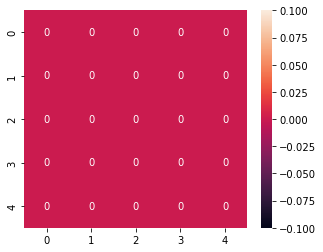

In [20]:
class SensorInputDatasetTranslation(Dataset):
    '''Sensor reading input dataset -- for multi TX
       Output is image, model as a image segmentation problem
    '''
    def __init__(self, root_dir: str, transform=None):
        '''
        Args:
            root_dir:  directory with all the images
            labels:    labels of images
            transform: optional transform to be applied on a sample
        '''
        self.root_dir = root_dir
        self.transform = transform
        self.length = len(os.listdir(self.root_dir))
        self.sample_per_label = self.get_sample_per_label()

    def __len__(self):
        return self.length * self.sample_per_label

    def __getitem__(self, idx):
        folder = int(idx / self.sample_per_label)
        folder = format(folder, '06d')
        matrix_name = str(idx % self.sample_per_label) + '.npy'
        matrix_path = os.path.join(self.root_dir, folder, matrix_name)
        target_name = str(idx % self.sample_per_label) + '.target.npy'
        target_img, target_float = self.get_translation_target(folder, target_name)
        matrix = np.load(matrix_path)
        if self.transform:
            matrix = self.transform(matrix)
        target_num = len(target_float)
        sample = {'matrix': matrix, 'target': target_img, 'target_float': target_float, 'target_num': target_num, 'index': idx}
        return sample

    def get_sample_per_label(self):
        folder = glob.glob(os.path.join(self.root_dir, '*'))[0]
        samples = glob.glob(os.path.join(folder, '*.json'))
        return len(samples)

    def get_translation_target_old(self, folder: str, target_name: str):
        '''
        Args:
            folder      -- eg. 000001
            target_name -- eg. 0.target.npy
        Return:
            np.ndarray, n = 2, the pixels surrounding TX will be assigned some values
        '''
        location = np.load(os.path.join(self.root_dir, folder, target_name))
        num_tx = len(location)
        grid = np.zeros((Default.grid_length, Default.grid_length))
        for i in range(num_tx):
            x, y = location[i][0], location[i][1]
            target_float = (x, y)
            x, y = int(x), int(y)
            neighbor = []
            sum_weight = 0
            for i in [-1, 0, 1]:
                for j in [-1, 0, 1]:
                    nxt = (x + i, y + j)
                    if 0 <= nxt[0] < Default.grid_length and 0 <= nxt[1] < Default.grid_length:
                        weight = 1./Utility.distance((nxt[0] + 0.5, nxt[1] + 0.5), target_float)
                        sum_weight += weight
                        neighbor.append((nxt, weight))
            for n, w in neighbor:
                grid[n[0]][n[1]] += w / sum_weight * len(neighbor) * 3  # 2 is for adding weights
        grid = np.expand_dims(grid, 0)
        return grid.astype(np.float32), location.astype(np.float32)

    def get_translation_target_old2(self, folder: str, target_name: str):
        '''9 pixels divide a total of 27, the middle pixel gets 9, the other 8 pixels get 18 by some weights.
        Args:
            folder      -- eg. 000001
            target_name -- eg. 0.target.npy
        Return:
            np.ndarray, n = 2, the pixels surrounding TX will be assigned some values
        '''
        location = np.load(os.path.join(self.root_dir, folder, target_name))
        num_tx = len(location)
        grid = np.zeros((Default.grid_length, Default.grid_length))
        for i in range(num_tx):
            x, y = location[i][0], location[i][1]
            target_float = (x, y)
            x, y = int(x), int(y)
            grid[x][y] = 9
            neighbor = []
            sum_weight = 0
            for i in [-1, 0, 1]:
                for j in [-1, 0, 1]:
                    if i == 0 and j == 0:
                        continue
                    nxt = (x + i, y + j)
                    if 0 <= nxt[0] < Default.grid_length and 0 <= nxt[1] < Default.grid_length:
                        weight = 1./Utility.distance((nxt[0] + 0.5, nxt[1] + 0.5), target_float)
                        sum_weight += weight
                        neighbor.append((nxt, weight))
            for n, w in neighbor:
                grid[n[0]][n[1]] += w / sum_weight * 18
        grid = np.expand_dims(grid, 0)
        return grid.astype(np.float32), location.astype(np.float32)


    def get_translation_target_8sum9(self, folder: str, target_name: str):
        '''the sum of the 8 surrounding pixels is 9
        Args:
            folder      -- eg. 000001
            target_name -- eg. 0.target.npy
        Return:
            np.ndarray, n = 2, the pixels surrounding TX will be assigned some values
        '''
        location = np.load(os.path.join(self.root_dir, folder, target_name))
        num_tx = len(location)
        grid = np.zeros((Default.grid_length, Default.grid_length))
        for i in range(num_tx):
            x, y = location[i][0], location[i][1]
            target_float = (x, y)
            x, y = int(x), int(y)
            grid[x][y] = 9
            neighbor = []
            sum_weight = 0
            for i in [-1, 0, 1]:
                for j in [-1, 0, 1]:
                    if i == 0 and j == 0:
                        continue
                    nxt = (x + i, y + j)
                    if 0 <= nxt[0] < Default.grid_length and 0 <= nxt[1] < Default.grid_length:
                        weight = 1./Utility.distance((nxt[0] + 0.5, nxt[1] + 0.5), target_float)
                        sum_weight += weight
                        neighbor.append((nxt, weight))
            for n, w in neighbor:
                grid[n[0]][n[1]] += w / sum_weight * 9
        grid = np.expand_dims(grid, 0)
        return grid.astype(np.float32), location.astype(np.float32)  

    def gaussian(self, b_x, b_y, x, y):
        '''2D gaussian
        '''
        a, c = 10, 0.9
        dist = math.sqrt((x - b_x) ** 2 + (y - b_y) ** 2)
        return a * np.exp(- dist ** 2 / (2 * c ** 2))

    def get_translation_target(self, folder: str, target_name: str):
        '''try guassian peak
        Args:
            folder      -- eg. 000001
            target_name -- eg. 0.target.npy
        Return:
            np.ndarray, n = 2, the pixels surrounding TX will be assigned some values
        '''
        location = np.load(os.path.join(self.root_dir, folder, target_name))
        num_tx = len(location)
        grid = np.zeros((Default.grid_length, Default.grid_length))
        for i in range(num_tx):
            x, y = location[i][0], location[i][1]
            target_float = (x, y)
            x, y = int(x), int(y)
            neighbor = []
            sum_weight = 0
            for i in [-2, -1, 0, 1, 2]:
                for j in [-2, -1, 0, 1, 2]:
                    nxt = (x + i, y + j)
                    if 0 <= nxt[0] < Default.grid_length and 0 <= nxt[1] < Default.grid_length:
                        val = self.gaussian(target_float[0], target_float[1], nxt[0]+0.5, nxt[1]+0.5)
                        grid[nxt[0]][nxt[1]] = max(val, grid[nxt[0]][nxt[1]])
        grid = np.expand_dims(grid, 0)
        return grid.astype(np.float32), location.astype(np.float32)


    def save_object_detection_image(self, output_dir, pred_matrix, idx):
        '''Take a 2D matrix (one channel image) as input, output as an image with three channels (by duplication)
        Args:
            pred_matrix -- np.ndarray, n=2
        '''
        img = np.stack((pred_matrix, pred_matrix, pred_matrix), axis=2)
        filename = format(idx, '06d')
        path = os.path.join(output_dir, filename)
        np.save(path, img.astype(np.float32))
        return filename

    def save_object_detection_label(self, output_dir, idx, grid_len, pred_matrix, peak_threashold=0.3, debug=False):
        filename = format(idx, '06d') + '.txt'
        path = os.path.join(output_dir, filename)
        with open(path, 'w') as f:
            sample = self.__getitem__(idx)
            ground_truth = sample['target_float']
            for x, y in ground_truth:
                if debug:
                    print(x, y)
                if pred_matrix[int(x)][int(y)] > peak_threashold:
                    f.write('0 {} {} {} {}\n'.format(y / grid_len, x / grid_len, 5 / grid_len, 5 / grid_len))
                else:
                    print(f'index = {idx} no peak at ({x}, {y}), value is {pred_matrix[int(x)][int(y)]}')


tf = T.Compose([
     UniformNormalize(Default.noise_floor),                 # TUNE: Uniform normalization is better than the above minmax normalization
     T.ToTensor()])

# training
i = 30006
root_dir = './data/1016train'
sensor_input_dataset = SensorInputDatasetTranslation(root_dir=root_dir, transform=tf)
sensor_input_dataloader = DataLoader(sensor_input_dataset, batch_size=32, shuffle=True, num_workers=3, collate_fn=my_collate)
print('matrix shape:', sensor_input_dataset[i]['matrix'].shape)
print('matrix shape:', sensor_input_dataset[i]['matrix'])
print('target:', sensor_input_dataset[i]['target'])
print('target float:', sensor_input_dataset[i]['target_float'])
print('length:', sensor_input_dataset.__len__())
print('label per sample:', sensor_input_dataset.get_sample_per_label())

fig, ax = plt.subplots(1, figsize=(5, 4))
sns.heatmap(sensor_input_dataset[i]['target'][0][0:5, 0:5], annot=True)


print('---\n')
# testing
root_dir = './data/1016test'
sensor_input_test_dataset = SensorInputDatasetTranslation(root_dir=root_dir, transform=tf)
sensor_input_test_dataloader = DataLoader(sensor_input_test_dataset, batch_size=32, shuffle=True, num_workers=3, collate_fn=my_collate)
print('matrix type:', sensor_input_test_dataset[i]['matrix'].dtype)
print('target type:', sensor_input_test_dataset[i]['target'].dtype)
print('target float:', sensor_input_test_dataset[i]['target_float'])
print('target num:', sensor_input_test_dataset[i]['target_num'])
print(sensor_input_test_dataset.__len__())

<AxesSubplot:>

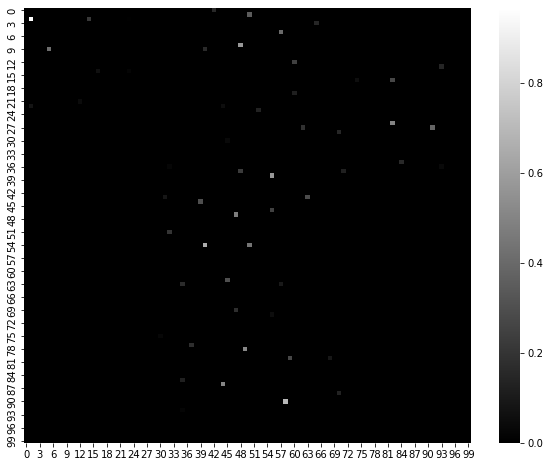

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(sensor_input_dataset[0]['matrix'][0], cmap='gray')

In [ ]:
i = 30837
matrix = sensor_input_test_dataset[i]['matrix']
matrix = matrix.numpy()[0]
sns.heatmap(matrix)
target = sensor_input_test_dataset[i]['target_float']
print(target)

In [ ]:
i = 0
matrix = sensor_input_dataset[i]['matrix']
matrix = matrix.numpy()[0]
sns.heatmap(matrix)
target = sensor_input_dataset[i]['target_float']
print(target)

## Prepare Dataset for Object Detection

In [ ]:
# training

root_dir = './data/1016train'
sensor_input_dataset = SensorInputDatasetTranslation(root_dir=root_dir, transform=tf)
sensor_input_dataloader = DataLoader(sensor_input_dataset, batch_size=32, shuffle=False, num_workers=1, collate_fn=my_collate)

images_dir = '/home/caitao/Project/PyTorch-YOLOv3/data/deepmtl-1016/images/train'
labels_dir = '/home/caitao/Project/PyTorch-YOLOv3/data/deepmtl-1016/labels/train'
list_path  = '/home/caitao/Project/PyTorch-YOLOv3/data/deepmtl-1016/train.txt'

device = torch.device('cuda')
# path5 = 'model/model1-12.13-net5-norm-32-splat.pt'
path5 = 'model/model1-12.18-net5-norm-32.pt'
model5_f5_norm = NetTranslation5_norm()
model5_f5_norm.load_state_dict(torch.load(path5))
model5_f5_norm = model5_f5_norm.to(device)
model5_f5_norm.eval()


with open(list_path, 'w') as f:
    for t, sample in enumerate(sensor_input_dataloader):
        if t % 10 == 9:
            print(t, end=' ')
        X = sample['matrix'].to(device)
        indx = sample['index']
        pred_matrix = model5_f5_norm(X)
        for idx, matrix in zip(indx, pred_matrix):
            idx = idx.data.cpu().numpy()
            matrix = matrix.data.cpu().numpy()
            image_name = sensor_input_dataset.save_object_detection_image(images_dir, matrix[0], idx)
            sensor_input_dataset.save_object_detection_label(labels_dir, idx, Default.grid_length, matrix[0])
            path = os.path.join(images_dir, image_name) + '.npy'
            f.write(path + '\n')


# testing or valid

root_dir = './data/1016test'
sensor_input_test_dataset = SensorInputDatasetTranslation(root_dir=root_dir, transform=tf)
sensor_input_test_dataloader = DataLoader(sensor_input_test_dataset, batch_size=32, shuffle=False, num_workers=1, collate_fn=my_collate)

images_dir  = '/home/caitao/Project/PyTorch-YOLOv3/data/deepmtl-1016/images/val'
labels_dir  = '/home/caitao/Project/PyTorch-YOLOv3/data/deepmtl-1016/labels/val'
list_path   = '/home/caitao/Project/PyTorch-YOLOv3/data/deepmtl-1016/valid.txt'

with open(list_path, 'w') as f:
    for t, sample in enumerate(sensor_input_test_dataloader):
        if t % 10 == 9:
            print(t, end=' ')
        X = sample['matrix'].to(device)
        indx = sample['index']
        pred_matrix = model5_f5_norm(X)
        for idx, matrix in zip(indx, pred_matrix):
            idx = idx.data.cpu().numpy()
            matrix = matrix.data.cpu().numpy()
            image_name = sensor_input_test_dataset.save_object_detection_image(images_dir, matrix[0], idx)
            sensor_input_test_dataset.save_object_detection_label(labels_dir, idx, Default.grid_length, matrix[0])
            path = os.path.join(images_dir, image_name) + '.npy'
            f.write(path + '\n')

In [81]:
sensor_input_dataset[1]

{'matrix': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 'target': array([[[0.03663718, 0.30959007, 0.7611777 , ..., 0.        ,
          0.        , 0.        ],
         [0.242177  , 2.0464349 , 5.031494  , ..., 0.        ,
          0.        , 0.        ],
         [0.4657767 , 3.9358888 , 9.677025  , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]]], dtype=float32),
 'target_float': array([[ 2.5297704,  2.7286904],
        [30.761032 , 94.10868  ]], dtype

<AxesSubplot:>

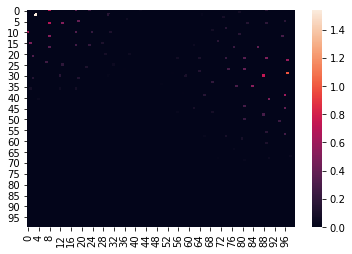

In [83]:
sns.heatmap(sensor_input_dataset[1]['matrix'][0])

<AxesSubplot:>

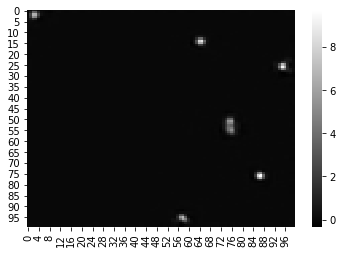

In [76]:
sns.heatmap(pred_matrix[1][0].data.cpu().numpy(), cmap='gray')

# 3 Model

NetTranslation1: https://nbviewer.jupyter.org/github/caitaozhan/deeplearning-localization/blob/a33c3beb435228c025b85c53ccf9257d5be6ae08/CNN-translation-multi.ipynb, three layers, groupnorm seems not helping

NetTranslation2:
https://nbviewer.jupyter.org/github/caitaozhan/deeplearning-localization/blob/2f65a0590994cb90b89ab0662ceda58c31253e55/CNN-translation-multi2.ipynb, 
Concatinating image translation and number of TX

NetTranslation3: https://nbviewer.jupyter.org/github/caitaozhan/deeplearning-localization/blob/34a4c8444806b75d89a4b64bc66e122c27c193db/CNN-translation-multi-min-dist-upbound.ipynb, increase filter size from 5 to 7

NetTranslation4: remove the "second CNN", a pure image-to-image translation

NetTranslation5: Add a layer so that it looks symmetric (the BEST)

NetTranslation6: incorporate U-Net ideas, i.e. first down sample and then upsample

NetTranslation7: incorporate U-Net ideas, i.e. first down sample and then upsample, add skip layers

In [5]:
# models not used


class NetTranslation4(nn.Module):
    '''Image translation.
       the first CNN is the same as NetTranslation, 
       the second one uses the output of the first CNN and output the # of Tx
       Assuming the input image is 1 x 100 x 100
    '''

    def __init__(self):
        super(NetTranslation4, self).__init__()
        self.conv11 = nn.Conv2d(1, 8,  7, padding=3)   # TUNE: a larger filter decrease miss, decrease localization error
        self.conv12 = nn.Conv2d(8, 32, 7, padding=3)
        self.conv13 = nn.Conv2d(32, 1, 7, padding=3)

    def forward(self, x):
        # first CNN input is 1 x 100 x 100
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        y = self.conv13(x)
        return y

net = NetTranslation4()
print(net)


class NetTranslation5(nn.Module):
    '''Image translation. Comparing with version 4, it adds a layer so it is symetric
       the first CNN is the same as NetTranslation, 
       the second one uses the output of the first CNN and output the # of Tx
       Assuming the input image is 1 x 100 x 100
    '''
    def __init__(self):
        super(NetTranslation5, self).__init__()
        self.conv1 = nn.Conv2d(1, 8,  7, padding=3)   # TUNE: a larger filter decrease miss, decrease localization error
        self.conv2 = nn.Conv2d(8, 32, 7, padding=3)
        self.conv3 = nn.Conv2d(32, 8, 7, padding=3)
        self.conv4 = nn.Conv2d(8, 1, 7, padding=3)

    def forward(self, x):
        # first CNN input is 1 x 100 x 100
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        y = self.conv4(x)
        return y

net = NetTranslation5()
print(net)


class NetTranslation5_5(nn.Module):
    '''Image translation. Comparing with version 4, it adds a layer so it is symetric
       the first CNN is the same as NetTranslation, 
       the second one uses the output of the first CNN and output the # of Tx
       Assuming the input image is 1 x 100 x 100
    '''
    def __init__(self):
        super(NetTranslation5_5, self).__init__()
        self.conv1 = nn.Conv2d(1,  8,  5, padding=2)
        self.conv2 = nn.Conv2d(8,  32, 5, padding=2)
        self.conv3 = nn.Conv2d(32, 8,  5, padding=2)
        self.conv4 = nn.Conv2d(8,  1,  5, padding=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        y = self.conv4(x)
        return y

net = NetTranslation5_5()
print(net)


class NetTranslation6(nn.Module):
    '''Image translation. this version mimics U-Net, it there is dimension reduction, but no skip connection
       the first CNN is the same as NetTranslation, 
       the second one uses the output of the first CNN and output the # of Tx
       Assuming the input image is 1 x 100 x 100
    '''
    def __init__(self):
        super(NetTranslation6, self).__init__()
        self.conv1 = nn.Conv2d(1, 8,  7, padding=3)   # TUNE: a larger filter decrease miss, decrease localization error
        self.conv2 = nn.Conv2d(8, 32, 7, padding=3)
        self.conv3 = nn.Conv2d(32, 8, 7, padding=3)
        self.conv4 = nn.Conv2d(8, 1, 7, padding=3)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

    def forward(self, x):
        # first CNN input is 1 x 100 x 100
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.relu(self.conv3(self.upsample(x)))
        y = self.conv4(self.upsample(x))
        return y

net = NetTranslation6()
print(net)


class NetTranslation7(nn.Module):
    '''Image translation. this version mimics U-Net, it there is dimension reduction, and has skip connection
       the first CNN is the same as NetTranslation, 
       the second one uses the output of the first CNN and output the # of Tx
       Assuming the input image is 1 x 100 x 100
    '''
    def __init__(self):
        super(NetTranslation7, self).__init__()
        factor = 2
        self.conv1 = nn.Conv2d(1,         8*factor,  7, padding=3)   # TUNE: a larger filter decrease miss, decrease localization error
        self.conv2 = nn.Conv2d(8*factor,  32*factor, 7, padding=3)
        self.conv3 = nn.Conv2d(32*factor, 8*factor, 7, padding=3)
        self.conv4 = nn.Conv2d(8*factor,  1, 7, padding=3)
        self.conv5 = nn.Conv2d(1, 1, 7, padding=3)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

    def forward(self, x):
        # first CNN input is 1 x 100 x 100
        x1   = F.relu(self.conv1(x))
        x1down = F.max_pool2d(x1, 2)
        x2   = F.relu(self.conv2(x1down))
        x2down = F.max_pool2d(x2, 2)
        x3   = F.relu(self.conv3(x2down))
        x3up = self.upsample(x3)
        x4   = self.conv4(x3up + x1down)       # skip connection
        x4up = self.upsample(x4)
        y = self.conv5(x + x4up)
        return y

net = NetTranslation7()
print(net)


"""
In the two CNN in a sequence method. the second CNN that predicts # of TX will affect the output of the first CNN
--> two CNN in a sequence may be a bad idea
--> how about two CNN in parallel
"""
class NetNumTx3(nn.Module):
    """this CNN predicts # of TX """

    def __init__(self, max_ntx):
        super(NetNumTx3, self).__init__()
        self.conv1 = nn.Conv2d(1, 2, 3, padding=1)
        self.conv2 = nn.Conv2d(2, 4, 3, padding=1)
        self.conv3 = nn.Conv2d(4, 8, 3, padding=1)
        self.conv4 = nn.Conv2d(8, 16, 3, padding=1)
        self.conv5 = nn.Conv2d(16, 16, 3, padding=1)
        self.norm1 = nn.GroupNorm(1, 2)
        self.norm2 = nn.GroupNorm(2, 4)
        self.norm3 = nn.GroupNorm(4, 8)
        self.norm4 = nn.GroupNorm(8, 16)
        self.norm5 = nn.GroupNorm(8, 16)
        self.fc1 = nn.Linear(144, 8)
        self.fc2 = nn.Linear(8, max_ntx)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.norm1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.norm2(self.conv2(x))), 2)
        x = F.max_pool2d(F.relu(self.norm3(self.conv3(x))), 2)
        x = F.max_pool2d(F.relu(self.norm4(self.conv4(x))), 2)
        x = F.max_pool2d(F.relu(self.norm5(self.conv5(x))), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        y = self.fc2(x)
        return y

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

model2 = NetNumTx3(5)
print(model2)

NetTranslation4(
  (conv11): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv12): Conv2d(8, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv13): Conv2d(32, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
)


In [11]:
class NetTranslation5_norm(nn.Module):
    '''The chosen one!
       Image translation. Comparing with version 4, it adds a layer so it is symetric, it also has group normalization
       the first CNN is the same as NetTranslation, 
       the second one uses the output of the first CNN and output the # of Tx
       Assuming the input image is 1 x 100 x 100
    '''
    def __init__(self):
        super(NetTranslation5_norm, self).__init__()
        self.conv1 = nn.Conv2d(1,  8,  5, padding=2)   # TUNE: a larger filter decrease miss, decrease localization error
        self.conv2 = nn.Conv2d(8,  32, 5, padding=2)
        self.conv3 = nn.Conv2d(32, 8,  5, padding=2)
        self.conv4 = nn.Conv2d(8,  1,  5, padding=2)
        self.norm1 = nn.GroupNorm(4,  8)
        self.norm2 = nn.GroupNorm(16, 32)
        self.norm3 = nn.GroupNorm(4,  8)

    def forward(self, x):
        x = F.relu(self.norm1(self.conv1(x)))
        x = F.relu(self.norm2(self.conv2(x)))
        x = F.relu(self.norm3(self.conv3(x)))
        y = self.conv4(x)
        return y


net = NetTranslation5_norm()
print(net)

NetTranslation5_norm(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(8, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(8, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (norm1): GroupNorm(4, 8, eps=1e-05, affine=True)
  (norm2): GroupNorm(16, 32, eps=1e-05, affine=True)
  (norm3): GroupNorm(4, 8, eps=1e-05, affine=True)
)


## Utility

In [8]:
def make_zeros(batch=32, length=100):
    '''for the regulation in the loss function
    '''
    zeros = []
    for _ in range(batch):
        zero = np.zeros((length, length))
        zero = np.expand_dims(zero, 0)
        zeros.append(zero)
    return torch.as_tensor(zeros).to(torch.device('cuda'))


def plot_epoch_stats(train_losses1, train_losses2, train_errors1, train_errors2, test_losses1, test_losses2, test_errors1, test_errors2, test_misses1, test_falses1, test_num_tx):
    '''print the error and such of each epoch
    '''
    clear_output(True)
    plt.figure(figsize=(24, 18))
    plt.subplot(5, 2, 1)
    plt.title('train loss for image translation')
    plt.plot(train_losses1)
    plt.subplot(5, 2, 2)
    plt.title('train errors for image translation')
    train_errors1 = [val for sublist in train_errors1 for val in sublist]  # flatten a 2D matrix
    plt.plot(train_errors1)
    plt.subplot(5, 2, 3)
    plt.title('train loss for num of TX')
    plt.plot(train_losses2)
    plt.subplot(5, 2, 4)
    plt.title('train error for num of TX')
    plt.plot(train_errors2)
    plt.subplot(5, 2, 5)
    plt.title('test loss for image translation')
    plt.plot(test_losses1)
    plt.subplot(5, 2, 6)
    plt.title('test error for image translation')
    test_errors1 = [val for sublist in test_errors1 for val in sublist]
    plt.plot(test_errors1)
    plt.subplot(5, 2, 7)
    plt.title('test loss for num of TX')
    plt.plot(test_losses2)
    plt.subplot(5, 2, 8)
    plt.title('test error for num of TX')
    plt.plot(test_errors2)
    plt.subplot(5, 2, 9)
    plt.title('test miss for image translation')
    plt.plot(np.array(test_misses1)/np.array(test_num_tx))   # implicitly assuming each sample is "equal". Instead it is not. when averaging, samples with higher number of TX should weight more
    plt.subplot(5, 2, 10)
    plt.title('test false alarm for image translation')
    plt.plot(np.array(test_falses1)/np.array(test_num_tx))
    plt.show()
    print('train loss of image translation  =', np.mean(train_losses1))
    print('train loss of num of TX          =', np.mean(train_losses2))
    print('test  loss of image translation  =', np.mean(test_losses1))
    print('test  loss of num of TX          =', np.mean(test_losses2))
    print('train error of image translation =', np.mean(train_errors1))
    print('train error of num of TX         =', np.mean(train_errors2))
    print('test error of image translation  =', np.mean(test_errors1))
    print('test error of num of TX          =', np.mean(test_errors2))
    print('test falses of image translation =', np.sum(test_falses1)/np.sum(test_num_tx))
    print('test misses of image translation =', np.sum(test_misses1)/np.sum(test_num_tx))
    train_losses1_epoch.append((np.mean(train_losses1), np.std(train_losses1)))
    train_losses2_epoch.append((np.mean(train_losses2), np.std(train_losses2)))
    train_errors1_epoch.append((np.mean(train_errors1), np.std(train_errors1)))
    train_errors2_epoch.append((np.mean(train_errors2), np.std(train_errors2)))
    test_losses1_epoch.append((np.mean(test_losses1), np.std(test_losses1)))
    test_losses2_epoch.append((np.mean(test_losses2), np.std(test_losses2)))
    test_errors1_epoch.append((np.mean(test_errors1), np.std(test_errors1)))
    test_errors2_epoch.append((np.mean(test_errors2), np.std(test_errors2)))
    test_misses1_epoch.append((np.sum(test_misses1)/np.sum(test_num_tx)))
    test_falses1_epoch.append((np.mean(test_falses1)/np.sum(test_num_tx)))


def plot_epoch_stats_num_tx(train_losses2, train_errors2, test_losses2, test_errors2, test_num_tx):
    '''print the error and such of each epoch
    '''
    clear_output(True)
    plt.figure(figsize=(24, 10))
    plt.subplot(2, 2, 1)
    plt.title('train loss for num of TX')
    plt.plot(train_losses2)
    plt.subplot(2, 2, 2)
    plt.title('train error for num of TX')
    plt.plot(train_errors2)
    plt.subplot(2, 2, 3)
    plt.title('test loss for num of TX')
    plt.plot(test_losses2)
    plt.subplot(2, 2, 4)
    plt.title('test error for num of TX')
    plt.plot(test_errors2)
    plt.show()
    print('train loss of num of TX          =', np.mean(train_losses2))
    print('test  loss of num of TX          =', np.mean(test_losses2))
    print('train error of num of TX         =', np.mean(train_errors2))
    print('test error of num of TX          =', np.mean(test_errors2))
    train_losses2_epoch.append((np.mean(train_losses2), np.std(train_losses2)))
    train_errors2_epoch.append((np.mean(train_errors2), np.std(train_errors2)))
    test_losses2_epoch.append((np.mean(test_losses2), np.std(test_losses2)))
    test_errors2_epoch.append((np.mean(test_errors2), np.std(test_errors2)))


def plot_epochs(train_losses2, test_losses2, train_errors2, test_errors2):
    print('train loss of num of TX   =', np.mean(train_losses2))
    print('test  loss of num of TX   =', np.mean(test_losses2))
    print('train error of num of TX  =', np.mean(train_errors2))
    print('test error of num of TX   =', np.mean(test_errors2))
    train_losses2_epoch.append((np.mean(train_losses2)))
    train_errors2_epoch.append((np.mean(train_errors2)))
    test_losses2_epoch.append((np.mean(test_losses2)))
    test_errors2_epoch.append((np.mean(test_errors2)))
    clear_output(True)
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.title('Loss', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.plot(train_losses2_epoch, label='Train', linewidth=5)
    plt.plot(test_losses2_epoch, label='Test', linewidth=5)
    plt.legend(fontsize=30)
    plt.subplot(1, 2, 2)
    plt.title('Error (1-accuracy)', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.plot(train_errors2_epoch, label='Train', linewidth=5)
    plt.plot(test_errors2_epoch, label='Test', linewidth=5)
    plt.legend(fontsize=30)
    plt.tight_layout()
    plt.show()

# Training

## Train only Image Translation

train loss of image translation = 0.034898755781695295
test  loss of image translation = 0.036161744112312724
train error = 0.7733602988953867
test error  = 0.8450131414267835
train miss = 0.028409090909090908
test  miss = 0.03676913803496082
train false = 0.02556818181818182
test  false = 0.03616636528028933


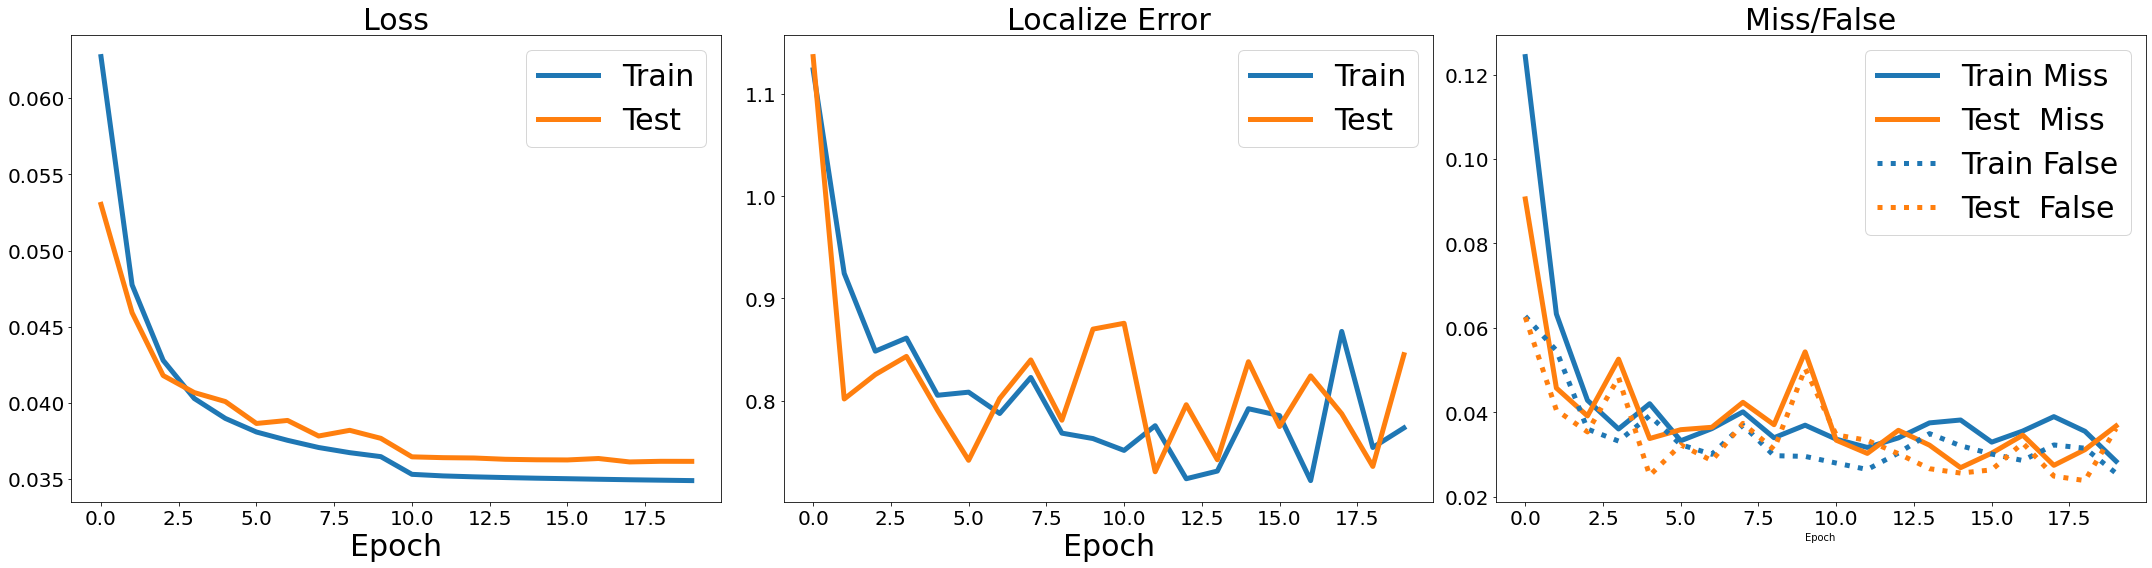

In [12]:
# %%time
# image translation problem
device     = torch.device('cuda')

model1 = NetTranslation5_norm()
path1 = 'model/model1-12.18-net5-norm-32.pt'

model1_minloss = 1000
model1 = model1.to(device)
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)#, weight_decay=0.0001''')
mse_loss   = nn.MSELoss()  # criterion is the loss function
l1_loss    = nn.L1Loss()
scheduler1 = optim.lr_scheduler.StepLR(optimizer1, step_size=10, gamma=0.1)

num_epochs = 20
train_losses1_epoch, train_errors1_epoch, train_misses1_epoch, train_falses1_epoch = [], [], [], []
test_losses1_epoch,  test_errors1_epoch,  test_misses1_epoch,  test_falses1_epoch  = [], [], [], []
print_every, error_every = 200, 200
# zeros  = make_zeros(batch=32, length=100)
# alpha  = 0    # control regulation

for epoch in range(num_epochs):
    print(f'epoch = {epoch}')
    train_losses1, train_errors1, train_misses1, train_falses1 = [], [], [], []
    test_losses1,  test_errors1,  test_misses1,  test_falses1  = [], [], [], []
    train_numtx, test_numtx = 0, 0
    model1.train()
    for t, sample in enumerate(sensor_input_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        y_num   = sample['target_num'].to(device)
        y_num2  = np.array(sample['target_num'])
        y_float = np.array(sample['target_float'])
        y_float = my_uncollate(y_num2, y_float)
        indx = sample['index']

        pred_matrix = model1(X)              # the model for iamge translation
        loss_matrix = mse_loss(pred_matrix, y)
#         regulation  = l1_loss(pred_matrix, zeros)
        loss1 = loss_matrix # + alpha * regulation
        optimizer1.zero_grad()
        loss1.backward()
        optimizer1.step()

        train_losses1.append(loss1.item())
        pred_matrix = pred_matrix.data.cpu().numpy()
        if t % error_every == 0:
            errors, misses, falses = Metrics.localization_error_image_continuous(pred_matrix, y_num2, y_float, indx, Default.grid_length, 1)
            train_errors1.extend(errors)
            train_misses1.extend(misses)
            train_falses1.extend(falses)
            train_numtx += y_num2.sum()
        if t % print_every == 0:
            print(f't = {t}, loss_matrix = {loss_matrix.item()}') #, regulation = {regulation.item()}')

    model1.eval()
    for t, sample in enumerate(sensor_input_test_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        y_num   = sample['target_num'].to(device)
        y_num2  = np.array(sample['target_num'])
        y_float = np.array(sample['target_float'])
        y_float = my_uncollate(y_num2, y_float)
        indx = sample['index']

        pred_matrix = model1(X)              # the model for iamge translation
        loss_matrix = mse_loss(pred_matrix, y)
#         regulation  = l1_loss(pred_matrix, zeros)
        loss1 = loss_matrix # + alpha*regulation

        test_losses1.append(loss1.item())
        pred_matrix = pred_matrix.data.cpu().numpy()
        if t % error_every == 0:
            errors, misses, falses = Metrics.localization_error_image_continuous(pred_matrix, y_num2, y_float, indx, Default.grid_length, 1)
            test_errors1.extend(errors)
            test_misses1.extend(misses)
            test_falses1.extend(falses)
            test_numtx += y_num2.sum()

    if np.mean(test_losses1) < model1_minloss:
        torch.save(model1.state_dict(), path1.format('best'))
        model1_minloss = np.mean(test_losses1)

    torch.save(model1.state_dict(), path1.format(epoch))
    
    scheduler1.step()
    clear_output(True)
    train_losses1_epoch.append(np.mean(train_losses1))
    test_losses1_epoch.append(np.mean(test_losses1))
    train_errors1 = [val for sublist in train_errors1 for val in sublist]  # flatten a 2D matrix
    test_errors1  = [val for sublist in test_errors1 for val in sublist]   # flatten a 2D matrix
    train_errors1_epoch.append(np.mean(train_errors1))
    test_errors1_epoch.append(np.mean(test_errors1))
    train_misses1_epoch.append(np.sum(train_misses1) / train_numtx)
    test_misses1_epoch.append(np.sum(test_misses1)   / test_numtx)
    train_falses1_epoch.append(np.sum(train_falses1) / train_numtx)
    test_falses1_epoch.append(np.sum(test_falses1)   / test_numtx)
    print('train loss of image translation =', train_losses1_epoch[-1])
    print('test  loss of image translation =', test_losses1_epoch[-1])
    print('train error =', train_errors1_epoch[-1])
    print('test error  =', test_errors1_epoch[-1])
    print('train miss =', train_misses1_epoch[-1])
    print('test  miss =', test_misses1_epoch[-1])
    print('train false =', train_falses1_epoch[-1])
    print('test  false =', test_falses1_epoch[-1])
    plt.figure(figsize=(30, 8))
    plt.subplot(1, 3, 1)
    plt.title('Loss', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_losses1_epoch, label='Train', linewidth=5)
    plt.plot(test_losses1_epoch, label='Test', linewidth=5)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=30)
    plt.subplot(1, 3, 2)
    plt.title('Localize Error', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_errors1_epoch, label='Train', linewidth=5)
    plt.plot(test_errors1_epoch, label='Test', linewidth=5)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=30)
    plt.subplot(1, 3, 3)
    plt.title('Miss/False', fontsize=30)
    plt.xlabel('Epoch')
    plt.plot(train_misses1_epoch, label='Train Miss',  linewidth=5, linestyle='-', color='#1f77b4')
    plt.plot(test_misses1_epoch,  label='Test  Miss',  linewidth=5, linestyle='-', color='#ff7f0e')
    plt.plot(train_falses1_epoch, label='Train False', linewidth=5, linestyle=':', color='#1f77b4')
    plt.plot(test_falses1_epoch,  label='Test  False', linewidth=5, linestyle=':', color='#ff7f0e')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=30)
    plt.tight_layout()
    plt.show()

In [ ]:
# %%time
# image translation problem
device     = torch.device('cuda')

path1 = 'model/model1-11.16-3.pt'
path2 = 'model/model2-11.16-3.pt'
model1_minloss = 1000
model2_minloss = 1000

max_ntx = 5
model1 = NetTranslation4()
model2 = NetNumTx2(max_ntx)

model1     = model1.to(device)
optimizer1 = optim.Adam(model1.parameters(), lr=0.01)
mse_loss   = nn.MSELoss()  # criterion is the loss function
l1_loss    = nn.L1Loss()
scheduler1 = optim.lr_scheduler.StepLR(optimizer1, step_size=5, gamma=0.1)

model2     = model2.to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=0.01)
cross_entro_loss = nn.CrossEntropyLoss()
scheduler2 = optim.lr_scheduler.StepLR(optimizer2, step_size=5, gamma=0.1)


num_epochs = 20
train_losses1_epoch, train_losses2_epoch = [], []
train_errors1_epoch, train_errors2_epoch = [], []
test_losses1_epoch,  test_losses2_epoch  = [], []
test_errors1_epoch,  test_errors2_epoch  = [], []
test_misses1_epoch,  test_falses1_epoch  = [], []
test_num_tx = []
print_every = 200
error_every = 200
zeros  = make_zeros(batch=32, length=100)
alpha  = 0    # control regulation

for epoch in range(num_epochs):
    print(f'epoch = {epoch}')
    train_losses1, train_losses2 = [], []
    train_errors1, train_errors2 = [], []
    test_losses1, test_losses2   = [], []
    test_errors1, test_errors2   = [], []
    test_misses1  = []
    test_falses1  = []
    test_num_tx = []
    model1.train()
    model2.train()
    for t, sample in enumerate(sensor_input_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        y_num   = sample['target_num'].to(device)
        y_num2  = np.array(sample['target_num'])
        y_float = np.array(sample['target_float'])
        y_float = my_uncollate(y_num2, y_float)
        indx = sample['index']

        pred_matrix = model1(X)              # the model for iamge translation
        loss_matrix = mse_loss(pred_matrix, y)
        regulation  = l1_loss(pred_matrix, zeros)
        loss1 = loss_matrix + alpha*regulation
        optimizer1.zero_grad()
        loss1.backward()
        optimizer1.step()

        pred_ntx    = model2(X)              # the model for num TX
        loss2 = cross_entro_loss(pred_ntx, y_num-1)  # 1 TX is class 0, 2 TX is class 1
        optimizer2.zero_grad()
        loss2.backward()
        optimizer2.step()

        train_losses1.append(loss1.item())
        train_losses2.append(loss2.item())
        pred_matrix = pred_matrix.data.cpu().numpy()
        _, pred_ntx = pred_ntx.data.cpu().max(1)
        pred_ntx = (pred_ntx+1).numpy()    # class 0 means 1 TX, class 1 means 2 TX etc...
        if t % error_every == 0:
            errors, misses, falses = Metrics.localization_error_image_continuous(pred_matrix, pred_ntx, y_float, indx, Default.grid_length, 1)
            train_errors1.extend(errors)
            ntx_correct = (pred_ntx == y_num2).sum()
            total = len(pred_ntx)
            train_errors2.append(1 - ntx_correct*1.0/total)
        if t % print_every == 0:
            print(f't = {t}, loss_matrix = {loss_matrix.item()}, loss_num_tx = {loss2.item()}, regulation = {regulation.item()}')

    model1.eval()
    model2.eval()
    for t, sample in enumerate(sensor_input_test_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        y_num   = sample['target_num'].to(device)
        y_num2  = np.array(sample['target_num'])
        y_float = np.array(sample['target_float'])
        y_float = my_uncollate(y_num2, y_float)
        indx = sample['index']

        pred_matrix = model1(X)              # the model for iamge translation
        loss_matrix = mse_loss(pred_matrix, y)
        regulation  = l1_loss(pred_matrix, zeros)
        loss1 = loss_matrix + alpha*regulation

        pred_ntx    = model2(X)              # the model for num TX
        loss2 = cross_entro_loss(pred_ntx, y_num-1)  # 1 TX is class 0, 2 TX is class 1

        test_losses1.append(loss1.item())
        test_losses2.append(loss2.item())
        pred_matrix = pred_matrix.data.cpu().numpy()
        _, pred_ntx = pred_ntx.data.cpu().max(1)
        pred_ntx = (pred_ntx+1).numpy()    # class 0 means 1 TX, class 1 means 2 TX etc...
        if t % error_every == 0:
            errors, misses, falses = Metrics.localization_error_image_continuous(pred_matrix, pred_ntx, y_float, indx, Default.grid_length, 1)
            test_errors1.extend(errors)
            test_misses1.extend(misses)
            test_falses1.extend(falses)
            test_num_tx.extend(list(y_num2))
            ntx_correct = (pred_ntx == y_num2).sum()
            total = len(pred_ntx)
            test_errors2.append(1 - ntx_correct*1.0/total)

    if np.mean(test_losses1) < model1_minloss:
        torch.save(model1.state_dict(), path1)
        model1_minloss = np.mean(test_losses1)
    if np.mean(test_losses2) < model2_minloss:
        torch.save(model2.state_dict(), path2)
        model2_minloss = np.mean(test_losses2)

    plot_epoch_stats(train_losses1, train_losses2, train_errors1, train_errors2, test_losses1, test_losses2, test_errors1, test_errors2, test_misses1, test_falses1, test_num_tx)
    scheduler1.step()
    scheduler2.step()

print('train loss for image translation')
for loss in train_losses1_epoch:
    print(loss)
print('train loss for num of TX')
for loss in train_losses2_epoch:
    print(loss)
print('train error for image translation')
for error in train_errors1_epoch:
    print(error)
print('train error for num of TX')
for error in train_errors2_epoch:
    print(error)
print('test loss for image translation')
for loss in test_losses1_epoch:
    print(loss)
print('test loss for num of TX')
for loss in test_losses2_epoch:
    print(loss)
print('test error for image translation')
for error in test_errors1_epoch:
    print(error)
print('test error for num of TX')
for error in test_errors2_epoch:
    print(error)
print('test misses for image translation')
for miss in test_misses1_epoch:
    print(miss)
print('test falses for image translation')
for false in test_falses1_epoch:
    print(false)

# Evaluation

In [ ]:
# PERFECT CNN2
# evaluation for all test samples

# path1 = 'model/model1-11.12.pt'
# path1 = 'model/model1-11.30-net4.pt'
# path1 = 'model/model1-11.30-net5.pt'
path1 = 'model/model1-12.2-net5-best.pt'
model1 = NetTranslation5()

device = torch.device('cuda')
model1.load_state_dict(torch.load(path1))
model1 = model1.to(device)
model1.eval()

test_index, test_errors1, test_misses1, test_falses1 = [], [], [], []
ntx_correct, ntx_total = 0, 0
tx_num_total = 0
test_index_ntx_wrong = []

for t, sample in enumerate(sensor_input_test_dataloader):
    if t % 10 == 9:
        print(t, end=' ')
    X = sample['matrix'].to(device)
    y = sample['target'].to(device)
    y_num   = sample['target_num'].to(device)
    y_num2  = np.array(sample['target_num'])
    y_float = np.array(sample['target_float'])
    y_float = my_uncollate(y_num2, y_float)
    indx = sample['index']

    pred_matrix = model1(X)              # the model for iamge translation

    pred_matrix = pred_matrix.data.cpu().numpy()
    errors, misses, falses = Metrics.localization_error_image_continuous(pred_matrix, y_num2, y_float, indx, Default.grid_length, 1)
    test_errors1.extend(errors)
    test_misses1.extend(misses)
    test_falses1.extend(falses)
    test_index.extend(indx.numpy())
    tx_num_total += y_num2.sum()

print()
test_errors1_tmp = [val for sublist in test_errors1 for val in sublist]
print('error', np.mean(test_errors1_tmp))
print('miss ', np.sum(test_misses1) / tx_num_total)
print('false', np.sum(test_falses1) / tx_num_total)

In [21]:
def myplot(X, pred, pred_n, y, indx, i):
    indx = int(indx)
    fig, axs = plt.subplots(1, 3, figsize=(30, 8))
    sns.heatmap(X[0], cmap='gray', annot=False, ax=axs[0])
    sns.heatmap(pred[0], cmap='gray', annot=False, ax=axs[1])
    sns.heatmap(y[0], cmap='gray', annot=False, ax=axs[2])
    sen_num = get_sen_num(indx, root_dir='data/1016test', sample_per_label=6)
    axs[0].set_title(f'{indx} - {i}. # Sen = {sen_num}')
    axs[1].set_title(f'# of predict TX {pred_n:.2f}')
    fig.tight_layout()

def myplot3(pred, y, y_float):
    '''
    Args:
        pred    -- array like -- 2d dimension pred matrix
        y       -- array like -- 2d dimension true matrix
        y_float -- array like -- (num_tx, 2), second dimension 2 means a pair of (x, y)
    '''
    print(y_float)
    fig, axs = plt.subplots(1, len(y_float), figsize=(25, 5))
    for i in range(len(y_float)):
        a, b = y_float[i]
        a, b = int(a), int(b)
        a1 = a-5 if a >= 5 else 0
        a2 = a+5 if a <= Default.grid_length-5 else Default.grid_length
        b1 = b-5 if b >= 5 else 0
        b2 = b+5 if b <= Default.grid_length-5 else Default.grid_length
        print(f'pred {i} ({a1}, {a2}), ({b1}, {b2})')
        sns.heatmap(pred[a1:a2,b1:b2], cmap='gray', annot=True, ax=axs[i])
        axs[i].set_title(f'pred {i} ({a}, {b})')
    fig.tight_layout()
    fig, axs = plt.subplots(1, len(y_float), figsize=(25, 5))
    for i in range(len(y_float)):
        a, b = y_float[i]
        a, b = int(a), int(b)
        a1 = a-5 if a >= 5 else 0
        a2 = a+5 if a <= Default.grid_length-5 else Default.grid_length
        b1 = b-5 if b >= 5 else 0
        b2 = b+5 if b <= Default.grid_length-5 else Default.grid_length
        print(f'y    {i} ({a1}, {a2}), ({b1}, {b2})')
        sns.heatmap(y[a1:a2, b1:b2], cmap='gray', annot=True, ax=axs[i])
        axs[i].set_title(f'y   {i} ({a}, {b})')
    fig.tight_layout()

## Compare different image translation models

target [[[93.80066  49.738213]
  [ 9.253068 79.828156]
  [85.35857  55.147835]
  [42.789665 94.9824  ]
  [40.149075 77.26688 ]]]
net4 loss matrix = 0.05166645348072052
net5 gaussian filter 5 norm loss    = 0.011209829710423946
net5 gaussian (filter7) loss matrix = 0.03498994559049606
net5 gaussian (filter5) loss matrix = 0.028832076117396355


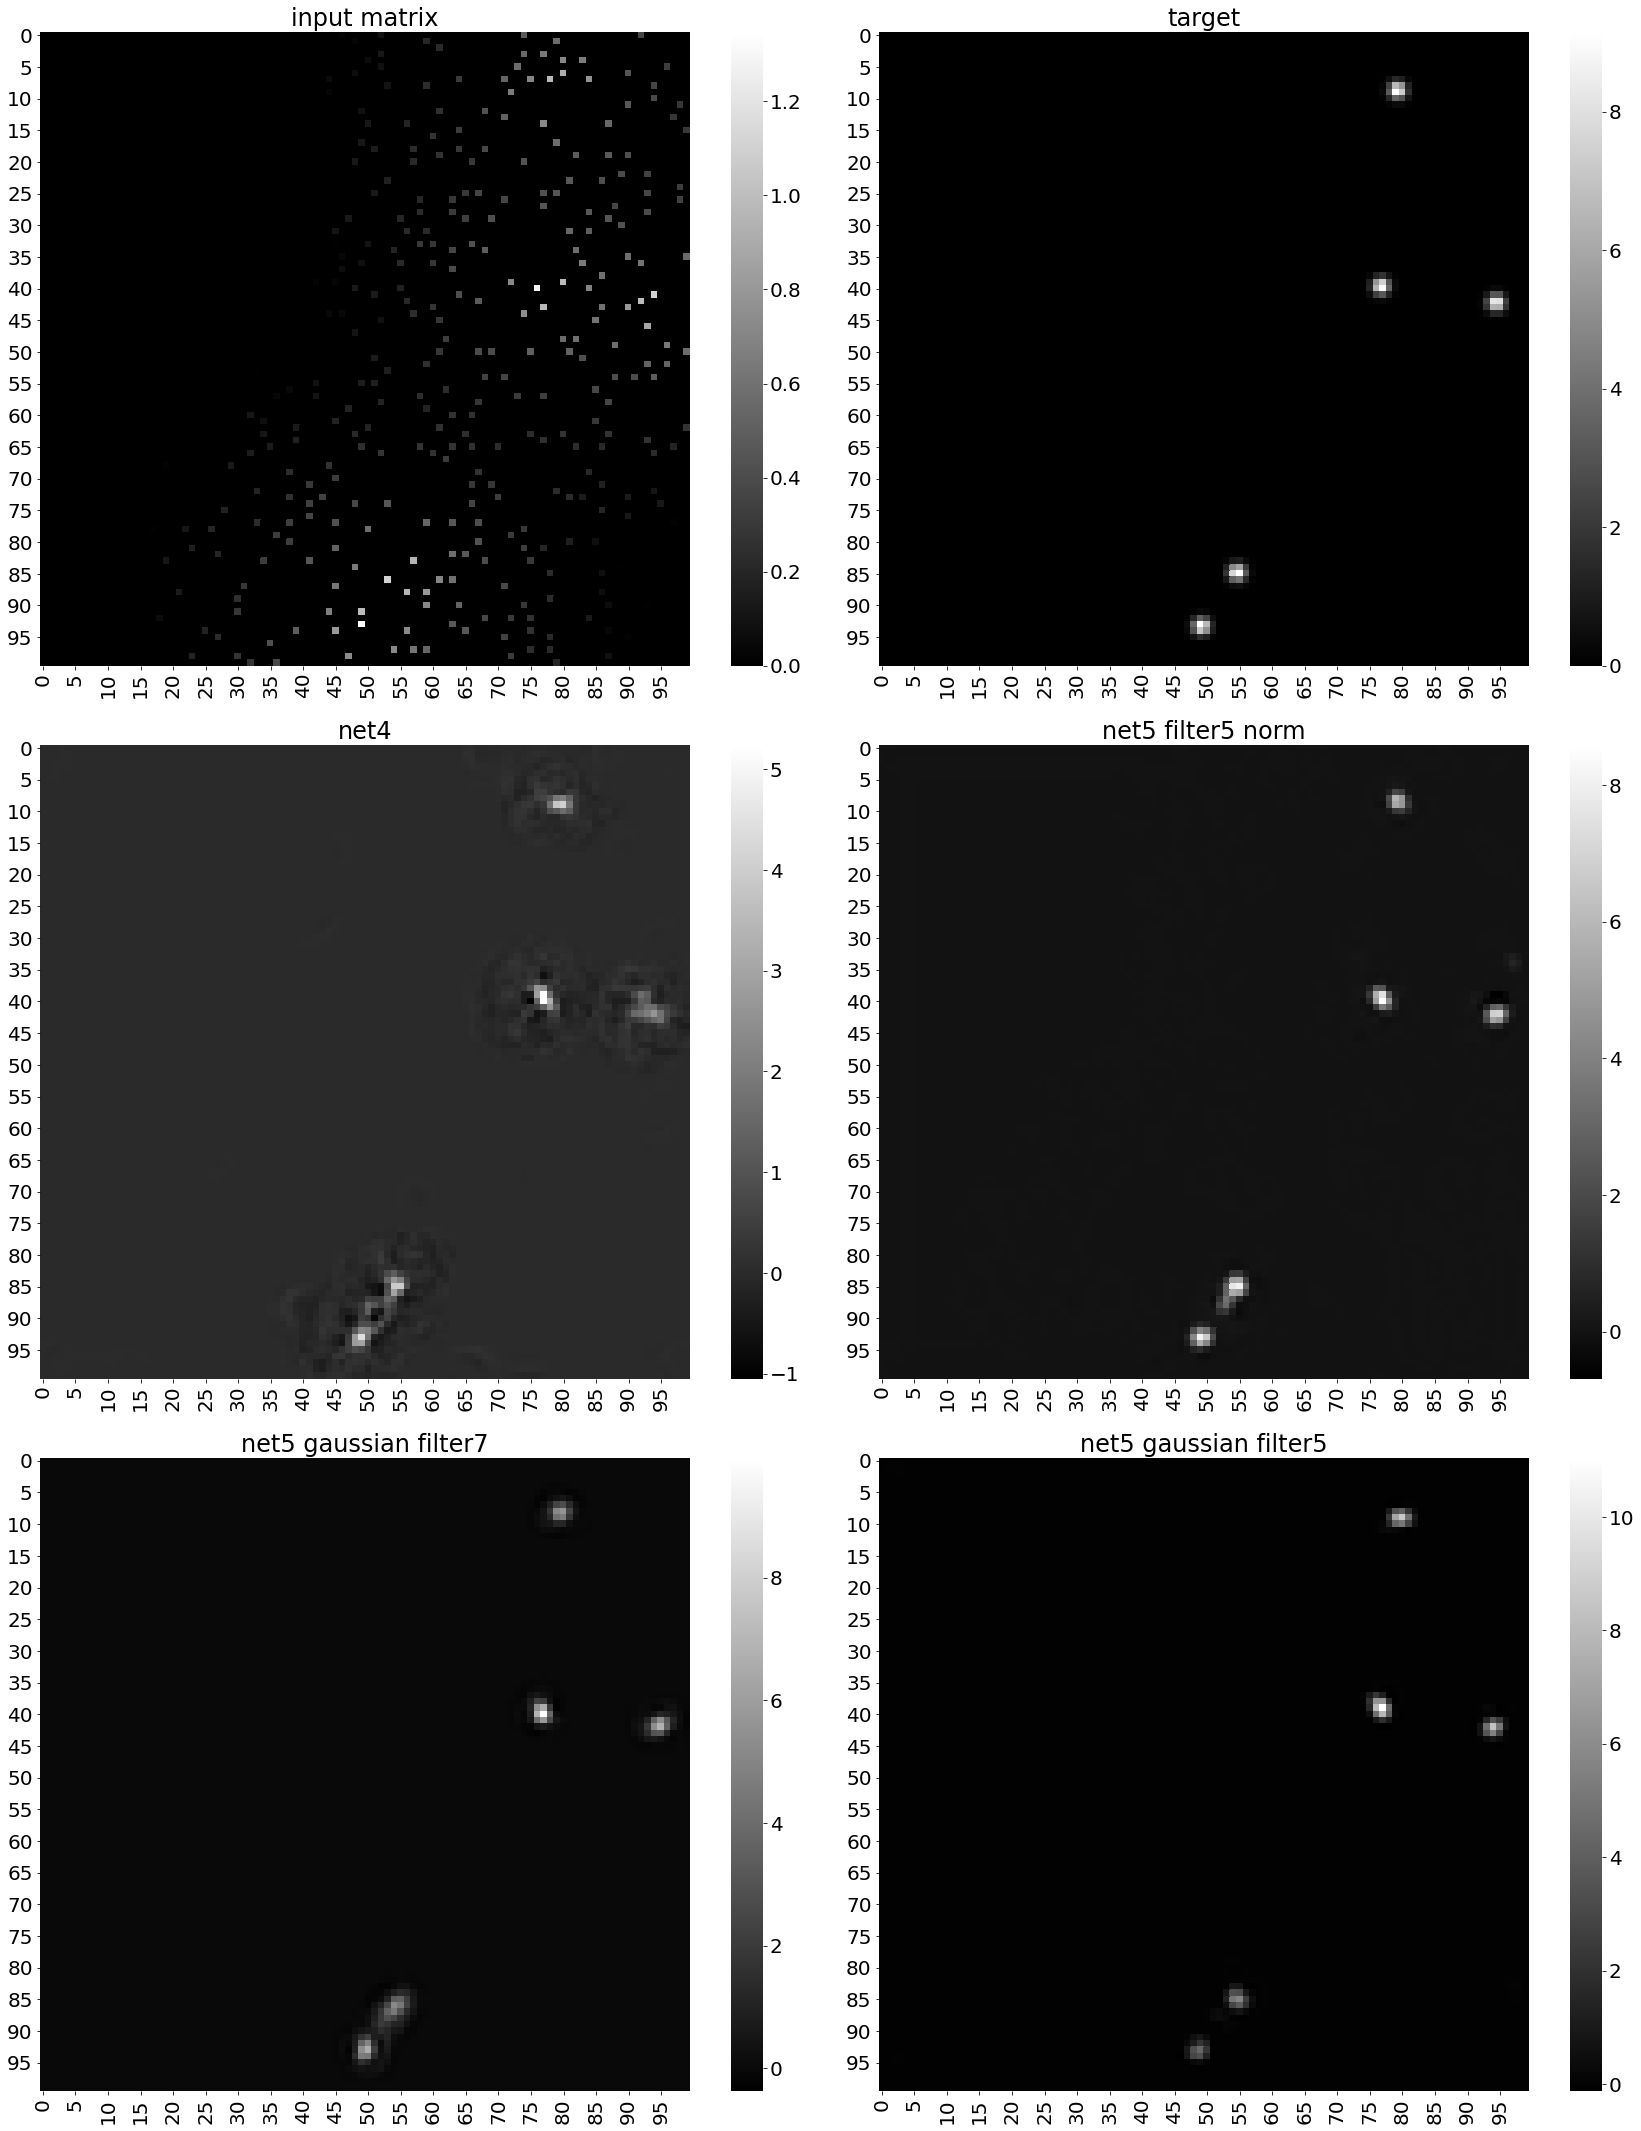

In [37]:
device = torch.device('cuda')

path4 = 'model/model1-11.12.pt'
model4 = NetTranslation4()
model4.load_state_dict(torch.load(path4))
model4 = model4.to(device)
model4.eval()

path5 = 'model/model1-12.2-net5-gaussian.pt'
model5_f7 = NetTranslation5()
model5_f7.load_state_dict(torch.load(path5))
model5_f7 = model5_f7.to(device)
model5_f7.eval()

path5 = 'model/model1-12.3-net5-f5-gaussian.pt'
model5_f5 = NetTranslation5_5()
model5_f5.load_state_dict(torch.load(path5))
model5_f5 = model5_f5.to(device)
model5_f5.eval()

path5 = 'model/model1-12.3-net5-f5-norm.pt'
model5_f5_norm = NetTranslation5_norm()
model5_f5_norm.load_state_dict(torch.load(path5))
model5_f5_norm = model5_f5_norm.to(device)
model5_f5_norm.eval()

criterion1 = nn.MSELoss()

idx = 17567    # three TX close to each other
# idx = 12651
# idx = 6764
# idx = 12179
# idx = 555
# idx = 10369
# idx = 9179     # use this in the paper
# idx = 11996
# idx = 13047
# idx = 12839
# idx = 1008  
# idx = 24
# idx = 85
# idx = 89
# idx = 92

net5pred = None
target   = None

def one_sample2(idx):
    '''used for comparing different image translation models
    '''
    device = torch.device('cuda')
    sample = sensor_input_test_dataset[idx]
    X = torch.as_tensor(sample['matrix'])
    X = X.unsqueeze(0).to(device)            # increase dimension to a batch
    y = torch.as_tensor(sample['target'])
    y = y.unsqueeze(0).to(device)            # increase dimension to a batch
    y_num = torch.as_tensor(sample['target_num'])
    y_num = y_num.unsqueeze(0).to(device)    # increase dimension to a batch
    y_f = np.expand_dims(sample['target_float'], 0)
    indx = np.expand_dims(np.array(sample['index']), 0)
    print('target', y_f)

    fig, axs = plt.subplots(3, 2, figsize=(24, 30))
    plt.rcParams['font.size'] = 20
    # input
    sns.heatmap(X[0][0].data.cpu().numpy(), cmap='gray', ax=axs.flat[0])
    axs.flat[0].set_title('input matrix')
    # target
    global target
    target = y[0][0].data.cpu().numpy()
    sns.heatmap(y[0][0].data.cpu().numpy(), cmap='gray', ax=axs.flat[1])
    axs.flat[1].set_title('target')
    # net4
    pred_matrix = model4(X)
    loss_matrix = criterion1(pred_matrix, y)
    print('net4 loss matrix =', loss_matrix.item())
    pred_matrix = pred_matrix[0][0].data.cpu().numpy()
    sns.heatmap(pred_matrix, cmap='gray', ax=axs.flat[2])
    axs.flat[2].set_title('net4')
    # net5
    pred_matrix = model5_f5_norm(X)
    loss_matrix = criterion1(pred_matrix, y)
    print('net5 gaussian filter 5 norm loss    =', loss_matrix.item())
    pred_matrix = pred_matrix[0][0].data.cpu().numpy()
    global net5pred
    net5pred = pred_matrix
    sns.heatmap(pred_matrix, cmap='gray', ax=axs.flat[3])
    axs.flat[3].set_title('net5 filter5 norm')

    # net5_
    pred_matrix = model5_f7(X)
    loss_matrix = criterion1(pred_matrix, y)
    print('net5 gaussian (filter7) loss matrix =', loss_matrix.item())
    pred_matrix = pred_matrix[0][0].data.cpu().numpy()
    sns.heatmap(pred_matrix, cmap='gray', ax=axs.flat[4])
    axs.flat[4].set_title('net5 gaussian filter7')

    # net5 filter 5
    pred_matrix = model5_f5(X)
    loss_matrix = criterion1(pred_matrix, y)
    print('net5 gaussian (filter5) loss matrix =', loss_matrix.item())
    pred_matrix = pred_matrix[0][0].data.cpu().numpy()
    sns.heatmap(pred_matrix, cmap='gray', ax=axs.flat[5])
    axs.flat[5].set_title('net5 gaussian filter5')    

    # net7
#     pred_matrix = model7(X)
#     loss_matrix = criterion1(pred_matrix, y)
#     print('net7 loss matrix =', loss_matrix.item())
#     pred_matrix = pred_matrix[0][0].data.cpu().numpy()
#     sns.heatmap(pred_matrix, cmap='gray', ax=axs.flat[3])
#     axs.flat[3].set_title('net7')
    fig.tight_layout()

one_sample2(idx)

## Part of a figure in the paper

target [[[49.505344 79.852905]
  [15.495159 97.642006]
  [92.46979  33.008553]
  [47.032413 77.064545]
  [91.56321  53.61198 ]]]
x1 shape torch.Size([1, 8, 100, 100])
x2 shape torch.Size([1, 32, 100, 100])
x3 shape torch.Size([1, 8, 100, 100])
y shape torch.Size([1, 1, 100, 100])


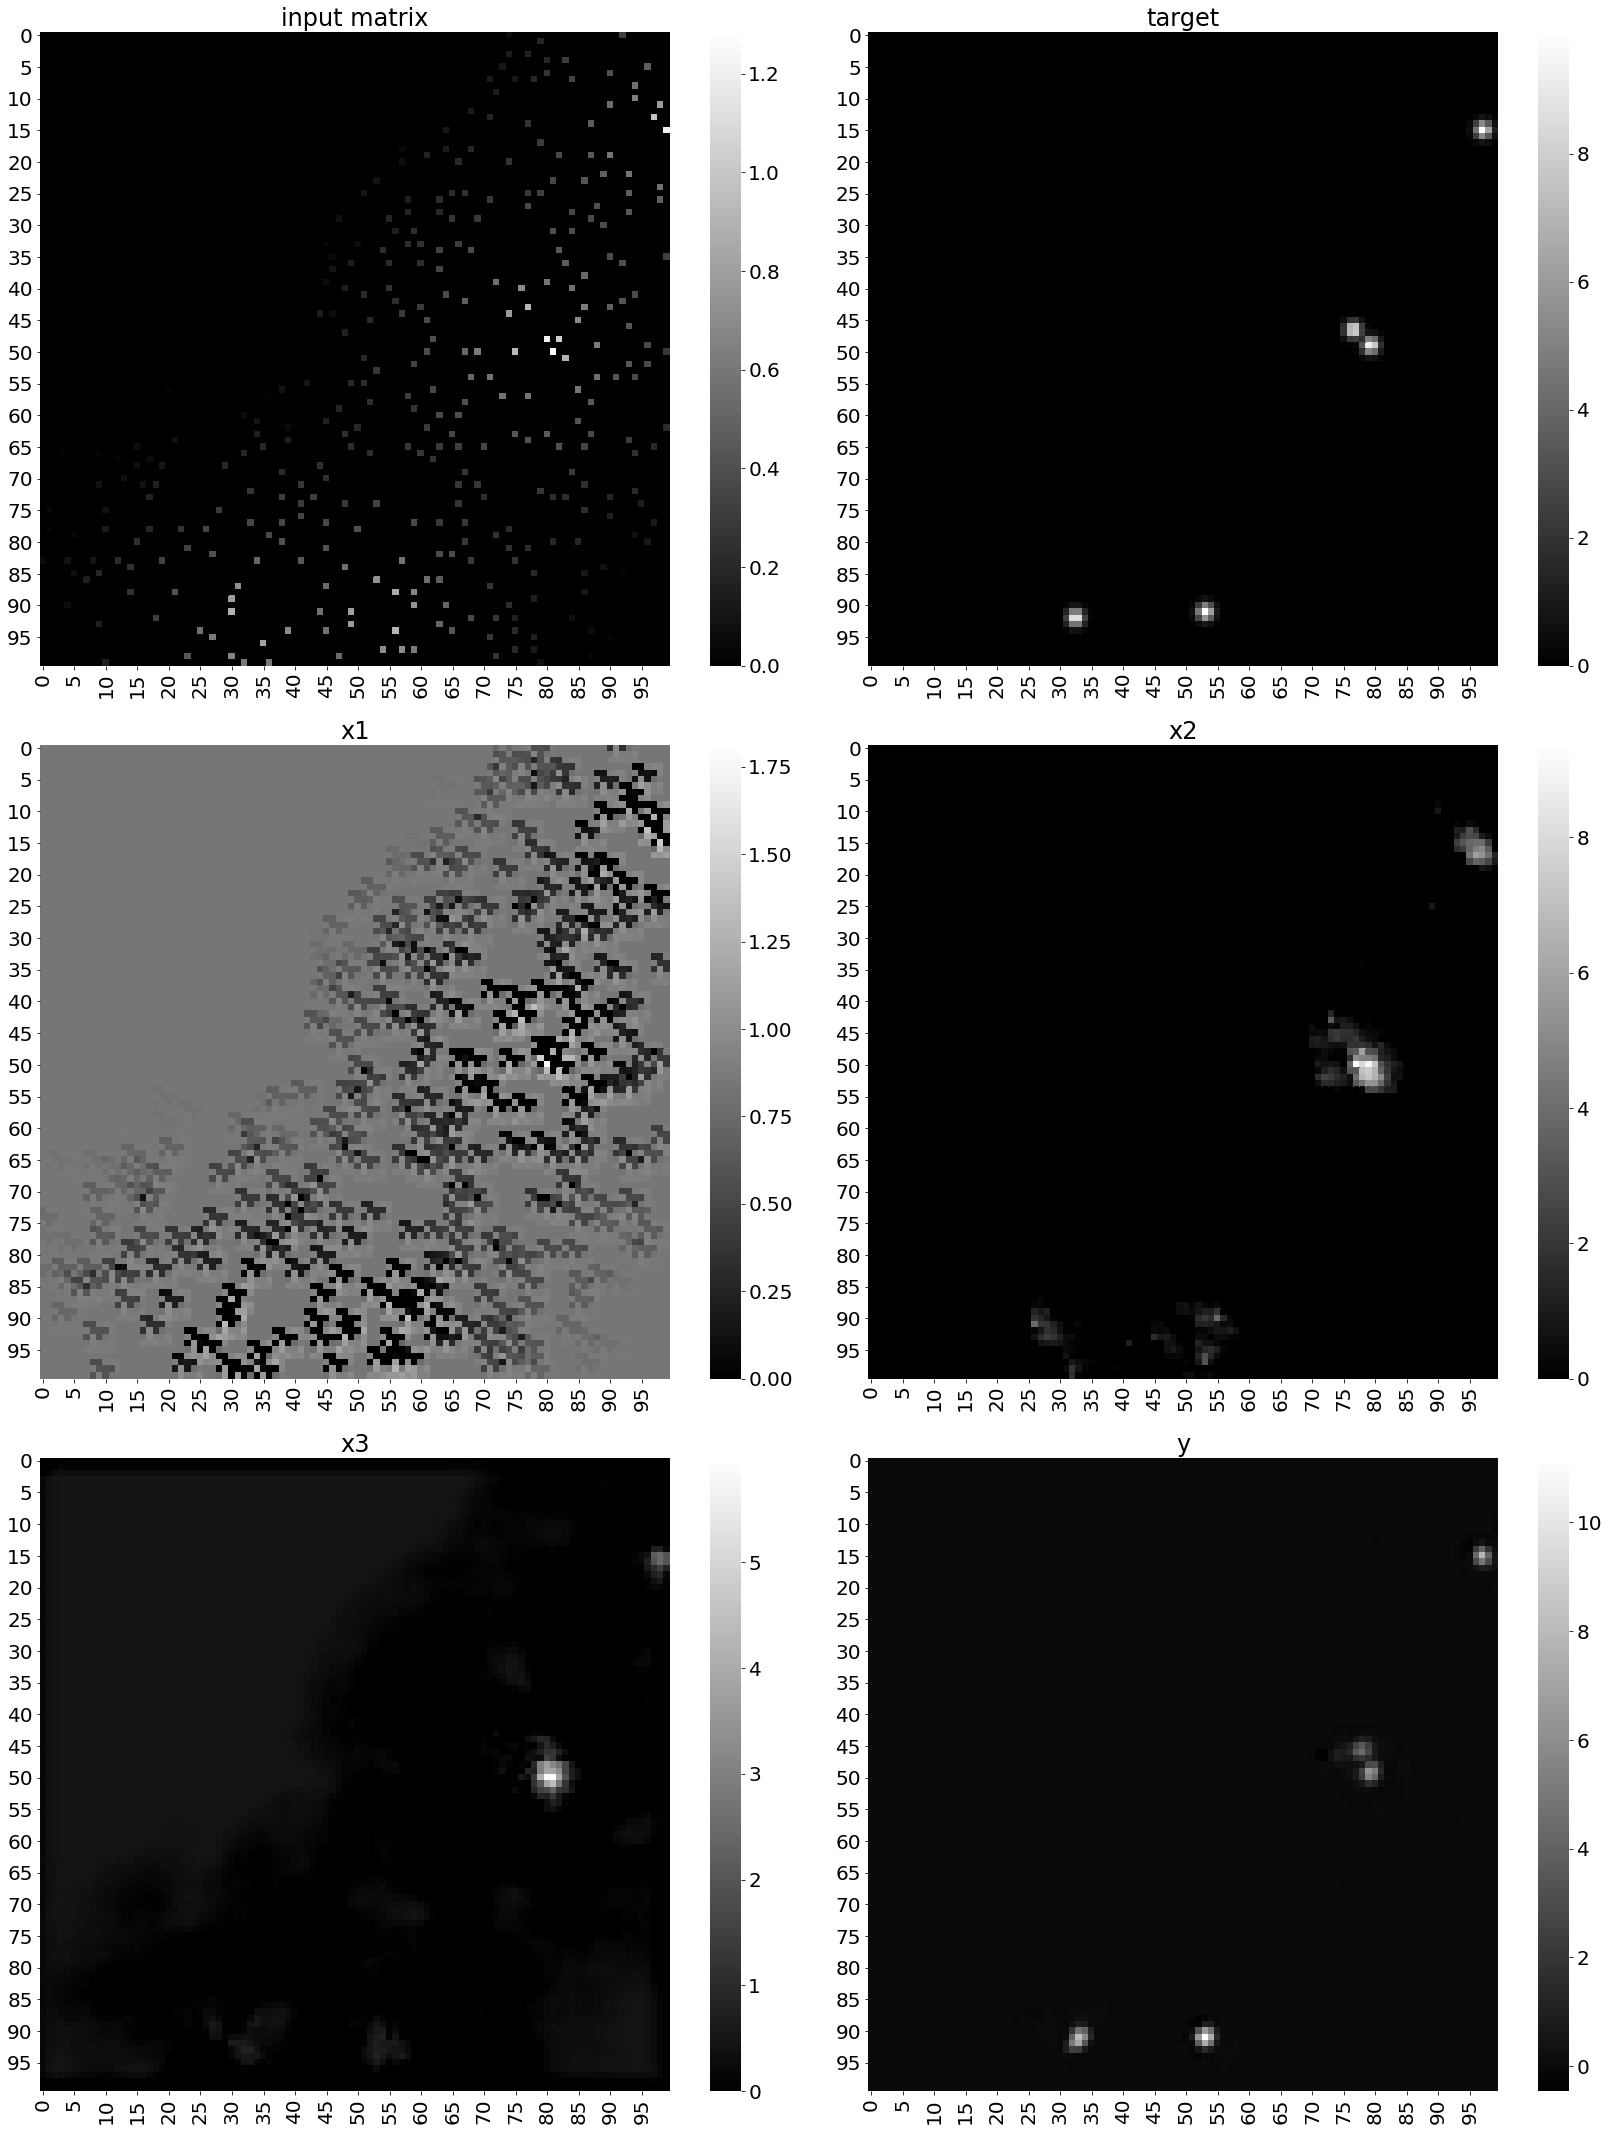

In [173]:
# the plot in the paper

device = torch.device('cuda')

path5 = 'model/model1-12.3-net5-f5-norm.pt'
model5_f5_norm = NetTranslation5_norm()
model5_f5_norm.load_state_dict(torch.load(path5))
model5_f5_norm = model5_f5_norm.to(device)
model5_f5_norm.eval()

idx = 9179     # use this in the paper

def one_sample2(idx):
    '''used for comparing different image translation models
    '''
    device = torch.device('cuda')
    sample = sensor_input_test_dataset[idx]
    X = torch.as_tensor(sample['matrix'])
    X = X.unsqueeze(0).to(device)            # increase dimension to a batch
    y = torch.as_tensor(sample['target'])
    y = y.unsqueeze(0).to(device)            # increase dimension to a batch
    y_num = torch.as_tensor(sample['target_num'])
    y_num = y_num.unsqueeze(0).to(device)    # increase dimension to a batch
    y_f = np.expand_dims(sample['target_float'], 0)
    indx = np.expand_dims(np.array(sample['index']), 0)
    print('target', y_f)

    fig, axs = plt.subplots(3, 2, figsize=(23.5, 30))
    plt.rcParams['font.size'] = 20
    # input
    sns.heatmap(X[0][0].data.cpu().numpy(), cmap='gray', ax=axs.flat[0])
    axs.flat[0].set_title('input matrix')
    # target
    target = y[0][0].data.cpu().numpy()
    sns.heatmap(y[0][0].data.cpu().numpy(), cmap='gray', ax=axs.flat[1])
    axs.flat[1].set_title('target')
    # net5
    x1, x2, x3, y = model5_f5_norm(X)
    print('x1 shape', x1.shape)
    print('x2 shape', x2.shape)
    print('x3 shape', x3.shape)
    print('y shape', y.shape)
    x1 = x1[0][0].data.cpu().numpy()
    x2 = x2[0][0].data.cpu().numpy()
    x3 = x3[0][0].data.cpu().numpy()
    y  = y[0][0].data.cpu().numpy()

    sns.heatmap(x1, cmap='gray', ax=axs.flat[2])
    axs.flat[2].set_title('x1')

    sns.heatmap(x2, cmap='gray', ax=axs.flat[3])
    axs.flat[3].set_title('x2')

    sns.heatmap(x3, cmap='gray', ax=axs.flat[4])
    axs.flat[4].set_title('x3')

    sns.heatmap(y, cmap='gray', ax=axs.flat[5])
    axs.flat[5].set_title('y')    

    fig.tight_layout()
    fig.savefig('visualize/input-layers-output.png')

one_sample2(idx)

## Test for one sample

In [ ]:
# Test for one sample

# idx = 15668  # two TX close, one peak covers the other
# idx = 7329  # two TX close, one peak covers the other
# idx = 18327    # one TX cannot meet peak threshold at low sensor density area
# idx = 2418   # edge issue
# idx = 8662    # one TX cannot meet peak threshold at low sensor density area
# idx = 12289   # one TX cannot meet peak threshold at low sensor density area
# idx = 12215 # too close to call (tctc)
# idx = 11221     # num of TX wrong, but peak finding is right

path1 = 'model/model1-11.30-net5.pt'
model1 = NetTranslation5()
model1.load_state_dict(torch.load(path1))
model1 = model1.to(device)

path2 = 'model/model2-11.19.pt'
max_ntx = 5
model2 = NetNumTx3(max_ntx)
model2.load_state_dict(torch.load(path2))
model2 = model2.to(device)


# idx = 17567    # three TX close to each other
idx = 12651
idx = 6764
idx = 12179
idx = 1

def one_sample(idx):
    device = torch.device('cuda')
    model1.eval()
    model2.eval()
    sample = sensor_input_test_dataset[idx]
    X = torch.as_tensor(sample['matrix'])
    X = X.unsqueeze(0).to(device)            # increase dimension to a batch
    y = torch.as_tensor(sample['target'])
    y = y.unsqueeze(0).to(device)            # increase dimension to a batch
    y_num = torch.as_tensor(sample['target_num'])
    y_num = y_num.unsqueeze(0).to(device)    # increase dimension to a batch
    y_f = np.expand_dims(sample['target_float'], 0)
    indx = np.expand_dims(np.array(sample['index']), 0)

    pred_matrix = model1(X)
    pred_ntx    = model2(pred_matrix)

    loss_matrix = criterion1(pred_matrix, y)
    loss_num_tx = criterion2(pred_ntx, y_num-1)
    print('loss matrix =', loss_matrix.item())
    print('loss num tx =', loss_num_tx.item())

    pred_matrix = pred_matrix.data.cpu().numpy()
    print('pred raw', pred_ntx)
    _, pred_ntx = pred_ntx.data.cpu().max(1)
    pred_ntx = (pred_ntx+1).numpy()    # class 0 means 1 TX, class 1 means 2 TX etc...
    print('pred ntx', pred_ntx)
    errors, misses, falses = Metrics.localization_error_image_continuous(pred_matrix.copy(), pred_ntx, y_f, indx, Default.grid_length, peak_threshold=1, debug=True)

    pred_matrix = pred_matrix[0][0]
    fig, axs = plt.subplots(1, 2, figsize=(24, 10))
    X = X[0][0].data.cpu().numpy()
    sns.heatmap(X, cmap='gray', ax=axs[0])
    axs[0].set_title('input matrix')
    sns.heatmap(pred_matrix, cmap='gray', ax=axs[1])
    axs[1].set_title('prediction')
    plt.tight_layout()
    np.savetxt('test.txt', pred_matrix)
    y = y.data.cpu().numpy()[0][0]
    y_f = y_f[0]
    myplot3(pred_matrix, y, y_f)

#     fig, axes = plt.subplots(2, int(len(y_f)/2 + 0.5), figsize=(25, 12))
#     for i in range(len(y_f)):
#         a, b = y_f[i]
#         a, b = int(a), int(b)
#         a1 = a-10 if a >= 10 else 0
#         a2 = a+10 if a <= Default.grid_length-10 else Default.grid_length
#         b1 = b-10 if b >= 10 else 0
#         b2 = b+10 if b <= Default.grid_length-10 else Default.grid_length
#         sns.heatmap(X[a1:a2,b1:b2], cmap='gray', annot=True, ax=axes.flat[i])
#         axes.flat[i].set_title(f'Input image at {i} ({a}, {b})')
    fig.tight_layout()

one_sample(idx)

## Test for one random batch

In [22]:
# Test for one random batch
plt.rcParams.update({'figure.max_open_warning': 0})
CUDA_LAUNCH_BLOCKING="1"

criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()

# path1 = 'model/model1-11.12.pt'
# model1 = NetTranslation4()
# model1.load_state_dict(torch.load(path1))
# model1 = model1.to(device)

path1 = 'model/model1-12.18-net5-norm-32-splat.pt'
model1 = NetTranslation5_norm()
model1.load_state_dict(torch.load(path1))
model1 = model1.to(device)
model1.eval()

for t, sample in enumerate(sensor_input_test_dataloader):
    if t == 0:
        continue
    X = sample['matrix'].to(device)
    y = sample['target'].to(device)
    y_num = sample['target_num'].to(device)
    y_num2  = np.array(sample['target_num'])
    y_float = np.array(sample['target_float'])
    y_float = my_uncollate(y_num2, y_float)
    indx = np.array(sample['index'])

    pred_matrix = model1(X)

    loss_matrix = criterion1(pred_matrix, y)
    print('loss matrix =', loss_matrix.item())

    losses = []
    for i, pred, yy in zip(range(len(y)), pred_matrix, y):
        pred, yy = pred[0].data.cpu().numpy(), yy[0].data.cpu().numpy()
        loss = Metrics.mseloss(pred, yy)
        losses.append((i, loss))
    losses.sort(key=lambda x : x[1])
    for idx, (i, loss) in enumerate(losses):
        print('{}: matrix loss = {:.5f}'.format(i, loss), end='   ')
        if idx % 5 == 4: 
            print()
    print()

    pred_matrix = pred_matrix.data.cpu().numpy()   # not using .numpy() will cause big issue
    errors, misses, falses = Metrics.localization_error_image_continuous(pred_matrix, y_num2, y_float, indx, Default.grid_length, peak_threshold=1, debug=True)
    errors = [val for sublist in errors for val in sublist]
    print('error', np.mean(errors), np.std(errors))
    print('miss ', np.sum(misses) / np.sum(y_num2))
    print('false', np.sum(falses) / np.sum(y_num2))
    break

X    = X.data.cpu().numpy()
# pred_matrix = pred_matrix.data.cpu().numpy()
# pred_ntx = pred_ntx.data.cpu().numpy()
y    = y.data.cpu().numpy()
indx = sample['index']

loss matrix = 0.05223527178168297
4: matrix loss = 0.00293   24: matrix loss = 0.00424   13: matrix loss = 0.00472   2: matrix loss = 0.00509   26: matrix loss = 0.00591   
15: matrix loss = 0.00677   19: matrix loss = 0.00786   27: matrix loss = 0.00790   29: matrix loss = 0.00853   28: matrix loss = 0.00901   
14: matrix loss = 0.01456   6: matrix loss = 0.01461   10: matrix loss = 0.01617   25: matrix loss = 0.01865   12: matrix loss = 0.02113   
20: matrix loss = 0.03298   17: matrix loss = 0.03350   11: matrix loss = 0.03650   18: matrix loss = 0.04161   21: matrix loss = 0.04169   
8: matrix loss = 0.04549   16: matrix loss = 0.05017   1: matrix loss = 0.08815   9: matrix loss = 0.09843   31: matrix loss = 0.10225   
5: matrix loss = 0.11557   7: matrix loss = 0.11922   3: matrix loss = 0.12331   23: matrix loss = 0.13412   30: matrix loss = 0.13917   
22: matrix loss = 0.15207   0: matrix loss = 0.16921   
0 5274 pred [(4.64, 65.65), (11.36, 92.36), (16.5, 81.0), (18.53, 97.55),

In [ ]:
# visualize the batch

for i in range(len(pred_matrix)):
    myplot(X[i], pred_matrix[i], y_num2[i], y[i], indx[i], i)
    print(i, end=' ')

# Mics

## Loss function

In [99]:
def mysoftmax(X):
    '''
    Args:
        X -- np.ndarray, n=2
    Return:
        np.ndarray, n=2
    '''
    X = np.exp(X)
    summ = np.sum(X, axis=1)
    for i in range(len(X)):
        X[i] /= summ[i]
    return X


def mylogsoftmax(X):
    '''
    Args:
        array -- np.ndarray, n=2
    Return:
        np.ndarray, n=2
    '''
    X = mysoftmax(X)
    return np.log(X)


def mynllloss(X, y):
    '''
    Args:
        X -- np.ndarray, n=2
        y -- np.ndarray, n=1
    Return:
        float
    '''
    weight = np.ones(len(y))
    L = [0] * len(X)
    denominator = 0
    for i in range(len(X)):
        L[i] = -weight[y[i]] * X[i][y[i]]
        denominator += weight[y[i]]
    summ = 0
    for i in range(len(X)):
        summ += L[i] / denominator
    return summ


pred_ntx2 = pred_ntx.data.cpu().numpy()
y_num2 = y_num.data.cpu().numpy()

softmax     = nn.Softmax(dim=1)
log_softmax = nn.LogSoftmax(dim=1)
nllloss     = nn.NLLLoss()

loss = cross_entro_loss(pred_ntx, y_num-1)
print(loss.item())

loss = nllloss(log_softmax(pred_ntx), y_num-1)
print(loss.item())

loss = mynllloss(mylogsoftmax(pred_ntx2), y_num2-1)
print(loss)

1.6348114013671875
1.6348114013671875
1.634811419993639


In [101]:
def mymseloss(pred, y):
    '''
    Args:
        pred -- np.ndarray, n=2
        y    -- np.ndarray, n=2
    Return:
        float
    '''
    n = len(pred) * len(pred[0])
    summ = np.sum((pred - y)**2)
    return summ / n